In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv("data\salary_dataset.csv")
df.dropna(inplace=True)

df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1, 'Other': 2}).infer_objects(copy=False)

C:\Users\Akhil\AppData\Local\Temp\ipykernel_15592\1240244.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1, 'Other': 2}).infer_objects(copy=False)


In [3]:
df['Education Level'] = df['Education Level'].str.strip().str.lower()
df['Education Level'] = df['Education Level'].replace({
    "high school": "high school",
    "bachelor's degree": "bachelor's",
    "master's degree": "master's",
    "masters": "master's",
    "phd": "phd",
    "ph.d": "phd",
    "ph.d.": "phd"
})
education_mapping = {
    "high school": 0,
    "bachelor's": 1,
    "master's": 2,
    "phd": 3
}
df['Education Level'] = df['Education Level'].map(education_mapping)

if 'Job Title' in df.columns:
    job_title_counts = df['Job Title'].value_counts()
    rare_titles = job_title_counts[job_title_counts <= 25].index
    df['Job Title'] = df['Job Title'].apply(lambda x: 'Others' if x in rare_titles else x)
    dummies = pd.get_dummies(df['Job Title'], drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop('Job Title', axis=1, inplace=True)

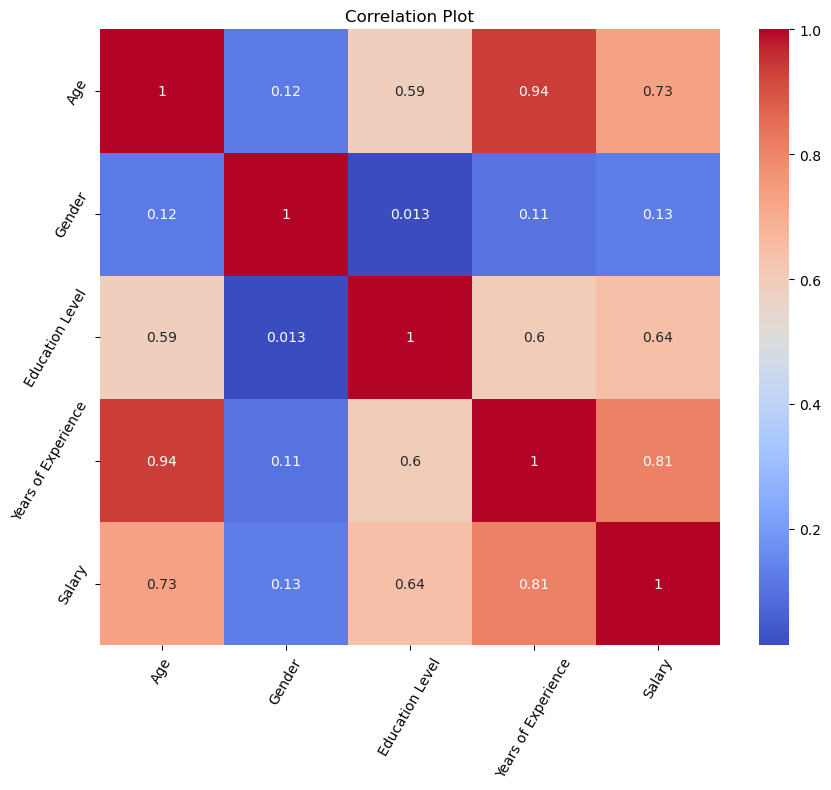

In [4]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Plot')
plt.xticks(rotation=60)
plt.yticks(rotation=60)
plt.show()

In [5]:
features = df.drop('Salary', axis=1)
target = df['Salary']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [6]:
rfr = RandomForestRegressor(n_estimators=20)
rfr.fit(x_train, y_train)
y_pred_rfr = rfr.predict(x_test)

In [7]:
print("MSE:", mean_squared_error(y_test, y_pred_rfr))
print("MAE:", mean_absolute_error(y_test, y_pred_rfr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rfr)))

MSE: 84808136.5064812
MAE: 3550.4047294367206
RMSE: 9209.133320051415


In [8]:
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("images/shap_summary_bar.png", dpi=300, bbox_inches='tight')
plt.clf()
shap.summary_plot(shap_values, x_test, show=False)
plt.tight_layout()
plt.savefig("images/shap_summary_dot.png", dpi=300, bbox_inches='tight')
plt.clf()
sample_explanation = shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=x_test.iloc[0],
    feature_names=x_test.columns
)
shap.plots.waterfall(sample_explanation, show=False)
plt.tight_layout()
plt.savefig("images/shap_waterfall.png", dpi=300, bbox_inches='tight')
plt.clf()

<Figure size 800x650 with 0 Axes>

C:\Users\Akhil\AppData\Local\Temp\ipykernel_15592\2383067387.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gender_mae = x_test_gender.groupby('Gender').apply(lambda g: mean_absolute_error(g['Actual'], g['Predicted'])).reset_index()


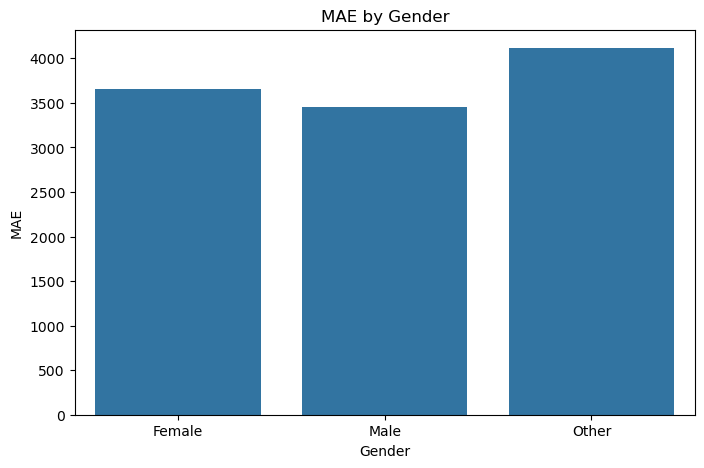

Disparate Impact Ratio (Female/Male): 0.88
Disparate Impact Ratio (Other/Male): 0.90


In [9]:
x_test_gender = x_test.copy()
x_test_gender['Gender'] = x_test_gender['Gender'].replace({0: 'Female', 1: 'Male', 2: 'Other'})
x_test_gender['Actual'] = y_test.values
x_test_gender['Predicted'] = y_pred_rfr
gender_mae = x_test_gender.groupby('Gender').apply(lambda g: mean_absolute_error(g['Actual'], g['Predicted'])).reset_index()
gender_mae.columns = ['Gender', 'MAE']
plt.figure(figsize=(8, 5))
sns.barplot(x='Gender', y='MAE', data=gender_mae)
plt.title('MAE by Gender')
plt.show()
mean_predicted_salary = x_test_gender.groupby('Gender')['Predicted'].mean()
dir_mf = mean_predicted_salary['Female'] / mean_predicted_salary['Male'] if mean_predicted_salary['Male'] > 0 else 0
dir_of = mean_predicted_salary['Other'] / mean_predicted_salary['Male'] if mean_predicted_salary['Male'] > 0 else 0
print(f'Disparate Impact Ratio (Female/Male): {dir_mf:.2f}')
print(f'Disparate Impact Ratio (Other/Male): {dir_of:.2f}')

In [10]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

st.set_page_config(page_title="Salary Predictor with SHAP", layout="wide")

st.title("💼 Salary Prediction with Explainability & Fairness")

df = pd.read_csv('data/salary_dataset.csv')
df.dropna(inplace=True)

df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1, 'Other': 2}).infer_objects(copy=False)
df['Education Level'] = df['Education Level'].str.strip().str.lower()
df['Education Level'] = df['Education Level'].replace({
    "high school": "high school",
    "bachelor's degree": "bachelor's",
    "master's degree": "master's",
    "masters": "master's",
    "phd": "phd",
    "ph.d": "phd",
    "ph.d.": "phd"
})
edu_map = {"high school": 0, "bachelor's": 1, "master's": 2, "phd": 3}
df['Education Level'] = df['Education Level'].map(edu_map)

if 'Job Title' in df.columns:
    job_title_counts = df['Job Title'].value_counts()
    rare_titles = job_title_counts[job_title_counts <= 25].index
    df['Job Title'] = df['Job Title'].apply(lambda x: 'Others' if x in rare_titles else x)
    dummies = pd.get_dummies(df['Job Title'], drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop('Job Title', axis=1, inplace=True)

features = df.drop('Salary', axis=1)
target = df['Salary']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

model = RandomForestRegressor(n_estimators=20)
model.fit(x_train, y_train)

st.header("📊 Predict Salary")
with st.form("predict_form"):
    age = st.number_input("Age", min_value=18, max_value=70, value=30)
    gender = st.selectbox("Gender", ['Male', 'Female', 'Other'])
    edu = st.selectbox("Education Level", list(edu_map.keys()))
    exp = st.slider("Years of Experience", 0, 50, 2)
    
    job_cols = [col for col in x_train.columns if col not in ['Age', 'Gender', 'Education Level', 'Years of Experience']]
    job_input = st.selectbox("Job Title", ['Others'] + [col for col in job_cols if col != 'Others'])
    
    submit = st.form_submit_button("Predict")

if submit:
    input_dict = {
        'Age': age,
        'Gender': {'Male': 1, 'Female': 0, 'Other': 2}[gender],
        'Education Level': edu_map[edu],
        'Years of Experience': exp
    }

    for col in job_cols:
        input_dict[col] = 1 if col == job_input else 0

    input_df = pd.DataFrame([input_dict])
    prediction = model.predict(input_df)[0]
    st.success(f"🧾 Predicted Salary: ${prediction:,.2f}")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)

    st.subheader("📌 Feature Importance (SHAP)")
    fig, ax = plt.subplots(figsize=(10, 4))
    shap.summary_plot(shap_values, x_test, plot_type='bar', show=False)
    st.pyplot(fig)

    x_test_gender = x_test.copy()
    x_test_gender['Gender'] = x_test_gender['Gender'].replace({0: 'Female', 1: 'Male', 2: 'Other'})
    x_test_gender['Actual'] = y_test.values
    x_test_gender['Predicted'] = model.predict(x_test)

    mean_pred_salary = x_test_gender.groupby('Gender')['Predicted'].mean()
    dir_fm = mean_pred_salary.get('Female', 0) / mean_pred_salary.get('Male', 1)
    dir_of = mean_pred_salary.get('Other', 0) / mean_pred_salary.get('Male', 1)

    st.subheader("⚖️ Disparate Impact Ratio")
    st.write(f"**Female/Male:** {dir_fm:.2f}")
    st.write(f"**Other/Male:** {dir_of:.2f}")

Overwriting app.py


In [ ]:
!streamlit run app.py